# Imports

In [9]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import sys
###
#!pip install openslide-python
#https://github.com/deroneriksson/python-wsi-preprocessing/
###
sys.path.append('../python-wsi-preprocessing/')
from deephistopath.wsi import slide, filter, tiles, util

import sys
sys.path.append('../fastai/') #fastai version 1.0
from fastai.vision import *
from fastai.core import parallel

import pandas as pd
import numpy as np
import os
from pathlib import Path
from functools import partial, update_wrapper
from tqdm import tqdm_notebook as tqdm
from enum import Enum
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
Image.MAX_IMAGE_PIXELS = 1000000000

PATH = Path('/home/Deep_Learner/work/network/datasets/Hypophysenadenome/')
FONT_PATH=PATH/'1984-Happines-Regular.ttf'
ROIS_CORTICOTROP = PATH/'rois_corticotrop'
ROIS_CORTICOTROP_FILTERED = PATH/'rois_corticotrop_filtered'
ROIS_GONADOTROP = PATH/'rois_gonadotrop'
ROIS_GONADOTROP_FILTERED = PATH/'rois_gonadotrop_filtered'
TILES_CORTICOTROP = PATH/'tiles_corticotrop'
TILES_GONADOTROP = PATH/'tiles_gonadotrop'

ROIS_EXPERIMENTING = PATH/'rois_experimenting'
ROIS_EXPERIMENTING_FILTERED = PATH/'rois_experimenting_filtered'
TILES_EXPERIMENTING = PATH/'tiles_experimenting'

slide.BASE_DIR = PATH
#slide.TRAIN_PREFIX = 'hypophysen'
#slide.SRC_TRAIN_DIR = ROIS_CORTICOTROP
slide.SRC_TRAIN_DIR = ROIS_GONADOTROP

def show(np):
    return util.np_to_pil(np)

Path.ls = lambda x: [p for p in list(x.iterdir()) if '.ipynb_checkpoints' not in p.name]

def show_multiple_images(path, rows = 3, figsize=(128, 64)):
    imgs = [open_image(p) for p in path.ls()]
    show_all(imgs=imgs, r=rows, figsize=figsize)
    
def show_multiple_images_big(path:pathlib.Path):
    for p in path.ls():
        plt.imshow(mpimg.imread(str(p)))
        plt.show()
        
class AdenomaType(Enum):
    experimenting = 0
    corticotrop = 1
    gonadotrop = 2

In [10]:
adenomaType = AdenomaType.corticotrop

if adenomaType == AdenomaType.gonadotrop:
    rois_filtered_path = ROIS_GONADOTROP_FILTERED
    rois_path = ROIS_GONADOTROP
    tiles_path = TILES_GONADOTROP
    
if adenomaType == AdenomaType.corticotrop:
    rois_filtered_path = ROIS_CORTICOTROP_FILTERED
    rois_path = ROIS_CORTICOTROP
    tiles_path = TILES_CORTICOTROP
    
if adenomaType == AdenomaType.experimenting:
    rois_filtered_path = ROIS_EXPERIMENTING_FILTERED
    rois_path = ROIS_EXPERIMENTING
    tiles_path = TILES_EXPERIMENTING

# Overwrite parts of wsi lib

In [11]:
slide.SCALE_FACTOR = 1
slide.BASE_DIR = PATH/'data'
tiles.SUMMARY_TITLE_FONT_PATH = str(FONT_PATH)
tiles.FONT_PATH = str(FONT_PATH)
tiles.DISPLAY_TILE_SUMMARY_LABELS = True
tiles.LABEL_ALL_TILES_IN_TOP_TILE_SUMMARY = True
tiles.BORDER_ALL_TILES_IN_TOP_TILE_SUMMARY = True
tiles.TISSUE_LOW_THRESH = 20

##################################################################################################################

slide.open_slide = slide.open_image

##################################################################################################################

def get_image_path(folder_path, slide_num):
    return folder_path.ls()[slide_num]

slide.get_filter_image_result = partial(get_image_path, rois_filtered_path)
slide.get_training_image_path = partial(get_image_path, rois_path)
slide.get_training_slide_path = partial(get_image_path, rois_path)

##################################################################################################################

def parse_dimensions_from_image_filename(img_path):
    shape = slide.open_image_np(img_path).shape
    return shape[1], shape[0], shape[1], shape[0]

slide.parse_dimensions_from_image_filename = parse_dimensions_from_image_filename

##################################################################################################################

def tile_to_pil_tile(tile):
  """
  Convert tile information into the corresponding tile as a PIL image read from the whole-slide image file.

  Args:
    tile: Tile object.

  Return:
    Tile as a PIL image.
  """
  t = tile
  filepath = slide.get_training_image_path(t.slide_num)
  img = slide.open_image_np(filepath)
  x, y = t.o_c_s, t.o_r_s
  w, h = t.o_c_e - t.o_c_s, t.o_r_e - t.o_r_s
  tile = img[t.o_r_s:t.o_r_e, t.o_c_s:t.o_c_e,:]
  tile_pil = util.np_to_pil(tile)
  return tile_pil

tiles.tile_to_pil_tile = tile_to_pil_tile

##################################################################################################################
def get_tile_image_path(tile):
  """
  Obtain tile image path based on tile information such as row, column, row pixel position, column pixel position,
  pixel width, and pixel height.

  Args:
    tile: Tile object.

  Returns:
    Path to image tile.
  """
  t = tile
  roi_name = slide.get_training_image_path(t.slide_num).stem
  tile_path = os.path.join(PATH, tiles_path,
                           roi_name + "-" + 'tile' + "-r%d-c%d-x%d-y%d-w%d-h%d" % (
                             t.r, t.c, t.o_c_s, t.o_r_s, t.o_c_e - t.o_c_s, t.o_r_e - t.o_r_s) + "." + 'png')
  return tile_path

slide.get_tile_image_path = get_tile_image_path

##################################################################################################################

def top_tiles(self):
    """
    Retrieve the top-scoring tiles.

    Returns:
       List of the top-scoring tiles.
    """
    sorted_tiles = self.tiles_by_score()
    top_tiles = [tile for tile in sorted_tiles
                 if check_tile(tile)]
    print(f'Number of top tiles/all tiles: {len(top_tiles)}/{len(sorted_tiles)}')
    return top_tiles

def check_tile(tile):
    width = tile.o_c_e - tile.o_c_s
    height = tile.o_r_e - tile.o_r_s
    return tile.score > 0.55 and width >= 0.7*tiles.COL_TILE_SIZE and height >= 0.7*tiles.ROW_TILE_SIZE


tiles.TileSummary.top_tiles = top_tiles

##################################################################################################################
from deephistopath.wsi.tiles import (hsv_saturation_and_value_factor, 
                                     hsv_purple_pink_factor, 
                                     tissue_quantity_factor, 
                                     tissue_quantity)

def score_tile(np_tile, tissue_percent, slide_num, row, col):
  """
  Score tile based on tissue percentage, color factor, saturation/value factor, and tissue quantity factor.

  Args:
    np_tile: Tile as NumPy array.
    tissue_percent: The percentage of the tile judged to be tissue.
    slide_num: Slide number.
    row: Tile row.
    col: Tile column.

  Returns tuple consisting of score, color factor, saturation/value factor, and tissue quantity factor.
  """
  color_factor = hsv_purple_pink_factor(np_tile)
  s_and_v_factor = hsv_saturation_and_value_factor(np_tile)
  amount = tissue_quantity(tissue_percent)
  quantity_factor = tissue_quantity_factor(amount)
  combined_factor = color_factor * s_and_v_factor
  score = tissue_percent * combined_factor / 1000.0
  # scale score to between 0 and 1
  score = 1.0 - (10.0 / (10.0 + score))
  print(f'tp: {tissue_percent}')
  print(f'cf: {combined_factor}')
  print(f'score: {score}')  
  return score, color_factor, s_and_v_factor, quantity_factor

tiles.score_tile = score_tile
#tiles.score_tile = tiles.score_tile
#############################################################################################################

# Filter images

In [12]:
def filter_roi(img_path:pathlib.Path, index:int):
    if img_path.suffix == '.png':
        try:
            img_pil = slide.open_image(img_path)
            img_np = util.pil_to_np_rgb(img_pil)
            grayscale_np = filter.filter_rgb_to_grayscale(img_np)
            complement_np = filter.filter_complement(grayscale_np)
            #otsu_np = filter.filter_otsu_threshold(complement_np).astype(np.bool)
            #filtered_img_np = util.mask_rgb(img_np, otsu_np)
            #filtered_img_pil = util.np_to_pil(filtered_img_np)
            #filtered_path = rois_filtered_path/f'{img_path.stem}-filtered{img_path.suffix}'
            #filtered_img_pil.save(filtered_path)
        except:
            print(img_path)
            
failed = []
try:
    parallel(filter_roi, rois_path.ls(), max_workers=25)
except:
    failed.append(img_path)
    
print(failed)

RGB                  | Time: 0:00:00.024588  Type: uint8   Shape: (1091, 946, 3)
Gray                 | Time: 0:00:00.032504  Type: uint8   Shape: (1091, 946)
Complement           | Time: 0:00:00.000180  Type: uint8   Shape: (1091, 946)


RGB                  | Time: 0:00:00.203236  Type: uint8   Shape: (3271, 2831, 3)
RGB                  | Time: 0:00:00.230578  Type: uint8   Shape: (2541, 3558, 3)
RGB                  | Time: 0:00:00.232424  Type: uint8   Shape: (2628, 3706, 3)
RGB                  | Time: 0:00:00.197889  Type: uint8   Shape: (2871, 2642, 3)
RGB                  | Time: 0:00:00.297907  Type: uint8   Shape: (3811, 2836, 3)
RGB                  | Time: 0:00:00.336206  Type: uint8   Shape: (4965, 3004, 3)
RGB                  | Time: 0:00:00.362873  Type: uint8   Shape: (3402, 4501, 3)
RGB                  | Time: 0:00:00.429662  Type: uint8   Shape: (5313, 3069, 3)
RGB                  | Time: 0:00:00.455421  Type: uint8   Shape: (4372, 4308, 3)
RGB                  | Time: 0:00:00.514702  Type: uint8   Shape: (5987, 3742, 3)
RGB                  | Time: 0:00:00.518307  Type: uint8   Shape: (4432, 5079, 3)
Gray                 | Time: 0:00:00.261656  Type: uint8   Shape: (2871, 2642)
Complement         

Gray                 | Time: 0:00:00.592045  Type: uint8   Shape: (3642, 4413)
Complement           | Time: 0:00:00.002247  Type: uint8   Shape: (3642, 4413)
Gray                 | Time: 0:00:00.227261  Type: uint8   Shape: (2320, 2746)
Complement           | Time: 0:00:00.000896  Type: uint8   Shape: (2320, 2746)
Gray                 | Time: 0:00:00.269641  Type: uint8   Shape: (1852, 4144)
Complement           | Time: 0:00:00.001069  Type: uint8   Shape: (1852, 4144)
RGB                  | Time: 0:00:00.470123  Type: uint8   Shape: (4490, 4715, 3)
RGB                  | Time: 0:00:00.333333  Type: uint8   Shape: (3571, 4257, 3)
Gray                 | Time: 0:00:02.392432  Type: uint8   Shape: (10502, 6108)
Complement           | Time: 0:00:00.029716  Type: uint8   Shape: (10502, 6108)
Gray                 | Time: 0:00:00.523999  Type: uint8   Shape: (3571, 4257)
Complement           | Time: 0:00:00.002045  Type: uint8   Shape: (3571, 4257)
Gray                 | Time: 0:00:00.736280 

Gray                 | Time: 0:00:00.306692  Type: uint8   Shape: (2686, 3449)
Complement           | Time: 0:00:00.001622  Type: uint8   Shape: (2686, 3449)
Gray                 | Time: 0:00:00.892528  Type: uint8   Shape: (4733, 5388)
Complement           | Time: 0:00:00.010255  Type: uint8   Shape: (4733, 5388)
RGB                  | Time: 0:00:00.045111  Type: uint8   Shape: (1437, 1370, 3)
Gray                 | Time: 0:00:00.061121  Type: uint8   Shape: (1437, 1370)
Complement           | Time: 0:00:00.000721  Type: uint8   Shape: (1437, 1370)
Gray                 | Time: 0:00:00.535289  Type: uint8   Shape: (3205, 4917)
Complement           | Time: 0:00:00.006343  Type: uint8   Shape: (3205, 4917)
RGB                  | Time: 0:00:01.976743  Type: uint8   Shape: (10709, 8848, 3)
RGB                  | Time: 0:00:02.306936  Type: uint8   Shape: (1920, 2316, 3)
RGB                  | Time: 0:00:00.197772  Type: uint8   Shape: (2559, 3595, 3)
Gray                 | Time: 0:00:00.14

Complement           | Time: 0:00:00.002091  Type: uint8   Shape: (4665, 2883)
Gray                 | Time: 0:00:00.415877  Type: uint8   Shape: (3967, 3031)
Complement           | Time: 0:00:00.004778  Type: uint8   Shape: (3967, 3031)
RGB                  | Time: 0:00:00.900470  Type: uint8   Shape: (6428, 6656, 3)
RGB                  | Time: 0:00:00.548681  Type: uint8   Shape: (1302, 1001, 3)
Gray                 | Time: 0:00:00.030468  Type: uint8   Shape: (1302, 1001)
Complement           | Time: 0:00:00.000336  Type: uint8   Shape: (1302, 1001)
RGB                  | Time: 0:00:00.118794  Type: uint8   Shape: (2496, 2423, 3)
Gray                 | Time: 0:00:00.174150  Type: uint8   Shape: (2496, 2423)
Complement           | Time: 0:00:00.000875  Type: uint8   Shape: (2496, 2423)
RGB                  | Time: 0:00:00.141501  Type: uint8   Shape: (3184, 2347, 3)
Gray                 | Time: 0:00:00.212783  Type: uint8   Shape: (3184, 2347)
Complement           | Time: 0:00:00.001

RGB                  | Time: 0:00:00.321853  Type: uint8   Shape: (3719, 4110, 3)
Gray                 | Time: 0:00:00.159955  Type: uint8   Shape: (2060, 2513)
Complement           | Time: 0:00:00.000689  Type: uint8   Shape: (2060, 2513)
RGB                  | Time: 0:00:00.299351  Type: uint8   Shape: (3418, 4356, 3)
Gray                 | Time: 0:00:00.476121  Type: uint8   Shape: (3719, 4110)
Complement           | Time: 0:00:00.005332  Type: uint8   Shape: (3719, 4110)
RGB                  | Time: 0:00:34.383884  Type: uint8   Shape: (6118, 8782, 3)
Gray                 | Time: 0:00:00.465914  Type: uint8   Shape: (3418, 4356)
Complement           | Time: 0:00:00.002125  Type: uint8   Shape: (3418, 4356)
RGB                  | Time: 0:00:08.458853  Type: uint8   Shape: (3599, 3771, 3)
RGB                  | Time: 0:00:00.373561  Type: uint8   Shape: (3614, 4957, 3)
Gray                 | Time: 0:00:00.414099  Type: uint8   Shape: (3599, 3771)
Complement           | Time: 0:00:00.

Complement           | Time: 0:00:00.002812  Type: uint8   Shape: (3770, 4675)
RGB                  | Time: 0:00:00.068788  Type: uint8   Shape: (2282, 1501, 3)
Gray                 | Time: 0:00:02.203127  Type: uint8   Shape: (8871, 7406)
Complement           | Time: 0:00:00.022888  Type: uint8   Shape: (8871, 7406)
Gray                 | Time: 0:00:00.079857  Type: uint8   Shape: (2282, 1501)
Complement           | Time: 0:00:00.000455  Type: uint8   Shape: (2282, 1501)
RGB                  | Time: 0:00:00.124061  Type: uint8   Shape: (3245, 1966, 3)
Gray                 | Time: 0:00:00.188163  Type: uint8   Shape: (3245, 1966)
Complement           | Time: 0:00:00.000909  Type: uint8   Shape: (3245, 1966)
RGB                  | Time: 0:00:00.337922  Type: uint8   Shape: (4355, 3572, 3)
Gray                 | Time: 0:00:00.491862  Type: uint8   Shape: (4355, 3572)
Complement           | Time: 0:00:00.002129  Type: uint8   Shape: (4355, 3572)
Gray                 | Time: 0:00:02.192955

Complement           | Time: 0:00:00.002463  Type: uint8   Shape: (4672, 4134)
RGB                  | Time: 0:00:00.395954  Type: uint8   Shape: (3218, 5912, 3)
Gray                 | Time: 0:00:00.610584  Type: uint8   Shape: (3218, 5912)
Complement           | Time: 0:00:00.002419  Type: uint8   Shape: (3218, 5912)
RGB                  | Time: 0:00:01.038966  Type: uint8   Shape: (5916, 8352, 3)
RGB                  | Time: 0:00:00.152455  Type: uint8   Shape: (2760, 2463, 3)
Gray                 | Time: 0:00:02.997582  Type: uint8   Shape: (8302, 10884)
Complement           | Time: 0:00:00.037487  Type: uint8   Shape: (8302, 10884)
Gray                 | Time: 0:00:00.229836  Type: uint8   Shape: (2760, 2463)
Complement           | Time: 0:00:00.000989  Type: uint8   Shape: (2760, 2463)
RGB                  | Time: 0:00:16.482296  Type: uint8   Shape: (8020, 3432, 3)
Gray                 | Time: 0:00:00.872920  Type: uint8   Shape: (8020, 3432)
Complement           | Time: 0:00:00.0

RGB                  | Time: 0:00:00.345949  Type: uint8   Shape: (4372, 3764, 3)
RGB                  | Time: 0:00:00.489782  Type: uint8   Shape: (6265, 3625, 3)
Gray                 | Time: 0:00:00.537614  Type: uint8   Shape: (4372, 3764)
Complement           | Time: 0:00:00.004198  Type: uint8   Shape: (4372, 3764)
Gray                 | Time: 0:00:00.734088  Type: uint8   Shape: (6265, 3625)
Complement           | Time: 0:00:00.007887  Type: uint8   Shape: (6265, 3625)
RGB                  | Time: 0:00:02.130227  Type: uint8   Shape: (1829, 1759, 3)
Gray                 | Time: 0:00:00.091463  Type: uint8   Shape: (1829, 1759)
Complement           | Time: 0:00:00.000517  Type: uint8   Shape: (1829, 1759)
RGB                  | Time: 0:00:00.081214  Type: uint8   Shape: (2565, 1600, 3)
RGB                  | Time: 0:00:46.246865  Type: uint8   Shape: (7378, 10016, 3)
Gray                 | Time: 0:00:00.128987  Type: uint8   Shape: (2565, 1600)
Complement           | Time: 0:00:00

Complement           | Time: 0:00:00.057346  Type: uint8   Shape: (11998, 12838)
Gray                 | Time: 0:00:00.325559  Type: uint8   Shape: (2695, 3622)
Complement           | Time: 0:00:00.001344  Type: uint8   Shape: (2695, 3622)
RGB                  | Time: 0:00:01.607946  Type: uint8   Shape: (1551, 1444, 3)
Gray                 | Time: 0:00:00.071928  Type: uint8   Shape: (1551, 1444)
Complement           | Time: 0:00:00.000272  Type: uint8   Shape: (1551, 1444)
Gray                 | Time: 0:00:03.836068  Type: uint8   Shape: (8237, 15014)
Complement           | Time: 0:00:00.047892  Type: uint8   Shape: (8237, 15014)
RGB                  | Time: 0:00:00.232248  Type: uint8   Shape: (2595, 4230, 3)
Gray                 | Time: 0:00:00.350189  Type: uint8   Shape: (2595, 4230)
Complement           | Time: 0:00:00.001399  Type: uint8   Shape: (2595, 4230)
RGB                  | Time: 0:00:00.036523  Type: uint8   Shape: (1410, 1109, 3)
Gray                 | Time: 0:00:00.04

Gray                 | Time: 0:00:02.151809  Type: uint8   Shape: (6643, 10317)
Complement           | Time: 0:00:00.025489  Type: uint8   Shape: (6643, 10317)
Gray                 | Time: 0:00:01.946028  Type: uint8   Shape: (6565, 9276)
Complement           | Time: 0:00:00.026134  Type: uint8   Shape: (6565, 9276)
Gray                 | Time: 0:00:00.839805  Type: uint8   Shape: (5621, 4532)
Complement           | Time: 0:00:00.010866  Type: uint8   Shape: (5621, 4532)
RGB                  | Time: 0:00:02.079003  Type: uint8   Shape: (12284, 8105, 3)
RGB                  | Time: 0:00:00.826662  Type: uint8   Shape: (8546, 4518, 3)
Gray                 | Time: 0:00:01.234684  Type: uint8   Shape: (8546, 4518)
Complement           | Time: 0:00:00.012788  Type: uint8   Shape: (8546, 4518)
RGB                  | Time: 0:00:45.320758  Type: uint8   Shape: (6556, 11242, 3)
RGB                  | Time: 0:00:02.751183  Type: uint8   Shape: (2472, 2047, 3)
Gray                 | Time: 0:00:00

Complement           | Time: 0:00:00.019945  Type: uint8   Shape: (5947, 8258)
RGB                  | Time: 0:00:00.042531  Type: uint8   Shape: (1102, 1982, 3)
Gray                 | Time: 0:00:00.070606  Type: uint8   Shape: (1102, 1982)
Complement           | Time: 0:00:00.000279  Type: uint8   Shape: (1102, 1982)
RGB                  | Time: 0:00:00.480671  Type: uint8   Shape: (8082, 2867, 3)
RGB                  | Time: 0:00:01.424957  Type: uint8   Shape: (7370, 9169, 3)
RGB                  | Time: 0:00:01.438448  Type: uint8   Shape: (1967, 1582, 3)
Gray                 | Time: 0:00:00.731710  Type: uint8   Shape: (8082, 2867)
Complement           | Time: 0:00:00.003432  Type: uint8   Shape: (8082, 2867)
Gray                 | Time: 0:00:00.097104  Type: uint8   Shape: (1967, 1582)
Complement           | Time: 0:00:00.000417  Type: uint8   Shape: (1967, 1582)
RGB                  | Time: 0:00:00.097055  Type: uint8   Shape: (2660, 1935, 3)
Gray                 | Time: 0:00:00.

RGB                  | Time: 0:00:00.683919  Type: uint8   Shape: (5075, 6147, 3)
Gray                 | Time: 0:00:01.559726  Type: uint8   Shape: (8405, 5639)
Complement           | Time: 0:00:00.019633  Type: uint8   Shape: (8405, 5639)
Gray                 | Time: 0:00:01.816852  Type: uint8   Shape: (6295, 8788)
Complement           | Time: 0:00:00.020944  Type: uint8   Shape: (6295, 8788)
Gray                 | Time: 0:00:01.033537  Type: uint8   Shape: (5075, 6147)
Complement           | Time: 0:00:00.012806  Type: uint8   Shape: (5075, 6147)
RGB                  | Time: 0:00:01.212541  Type: uint8   Shape: (1669, 1116, 3)
Gray                 | Time: 0:00:00.060053  Type: uint8   Shape: (1669, 1116)
Complement           | Time: 0:00:00.000225  Type: uint8   Shape: (1669, 1116)
RGB                  | Time: 0:00:00.697544  Type: uint8   Shape: (4483, 7483, 3)
Gray                 | Time: 0:00:01.094051  Type: uint8   Shape: (4483, 7483)
Complement           | Time: 0:00:00.012382

Complement           | Time: 0:00:00.002831  Type: uint8   Shape: (3229, 5382)
Gray                 | Time: 0:00:00.526222  Type: uint8   Shape: (3628, 4542)
Complement           | Time: 0:00:00.002420  Type: uint8   Shape: (3628, 4542)
RGB                  | Time: 0:01:40.923060  Type: uint8   Shape: (10941, 14419, 3)
RGB                  | Time: 0:00:01.140552  Type: uint8   Shape: (1503, 1370, 3)
Gray                 | Time: 0:00:00.062071  Type: uint8   Shape: (1503, 1370)
Complement           | Time: 0:00:00.000423  Type: uint8   Shape: (1503, 1370)
RGB                  | Time: 0:00:07.434892  Type: uint8   Shape: (4471, 2433, 3)
Gray                 | Time: 0:00:00.327990  Type: uint8   Shape: (4471, 2433)
Complement           | Time: 0:00:00.001550  Type: uint8   Shape: (4471, 2433)
RGB                  | Time: 0:00:00.602411  Type: uint8   Shape: (4202, 6887, 3)
RGB                  | Time: 0:00:56.273381  Type: uint8   Shape: (7230, 11908, 3)
RGB                  | Time: 0:00:

Gray                 | Time: 0:00:02.629584  Type: uint8   Shape: (9798, 8808)
Complement           | Time: 0:00:00.028716  Type: uint8   Shape: (9798, 8808)
RGB                  | Time: 0:00:17.663551  Type: uint8   Shape: (2413, 10717, 3)
Gray                 | Time: 0:00:00.827400  Type: uint8   Shape: (2413, 10717)
Complement           | Time: 0:00:00.011051  Type: uint8   Shape: (2413, 10717)
RGB                  | Time: 0:00:04.803478  Type: uint8   Shape: (1612, 4660, 3)
Gray                 | Time: 0:00:00.238444  Type: uint8   Shape: (1612, 4660)
Complement           | Time: 0:00:00.000974  Type: uint8   Shape: (1612, 4660)
RGB                  | Time: 0:00:06.341297  Type: uint8   Shape: (3585, 2649, 3)
Gray                 | Time: 0:00:00.300989  Type: uint8   Shape: (3585, 2649)
Complement           | Time: 0:00:00.001415  Type: uint8   Shape: (3585, 2649)
RGB                  | Time: 0:00:01.802082  Type: uint8   Shape: (2481, 1103, 3)
Gray                 | Time: 0:00:00.

Gray                 | Time: 0:00:00.239371  Type: uint8   Shape: (2620, 2559)
Complement           | Time: 0:00:00.001064  Type: uint8   Shape: (2620, 2559)
Gray                 | Time: 0:00:01.985499  Type: uint8   Shape: (10276, 5613)
Complement           | Time: 0:00:00.025563  Type: uint8   Shape: (10276, 5613)
RGB                  | Time: 0:00:23.464778  Type: uint8   Shape: (6525, 5325, 3)
RGB                  | Time: 0:04:27.515210  Type: uint8   Shape: (9907, 42016, 3)
RGB                  | Time: 0:00:00.750362  Type: uint8   Shape: (6484, 5285, 3)
Gray                 | Time: 0:00:01.201523  Type: uint8   Shape: (6525, 5325)
Complement           | Time: 0:00:00.015288  Type: uint8   Shape: (6525, 5325)
Gray                 | Time: 0:00:01.136507  Type: uint8   Shape: (6484, 5285)
Complement           | Time: 0:00:00.014829  Type: uint8   Shape: (6484, 5285)
RGB                  | Time: 0:00:03.052665  Type: uint8   Shape: (1757, 2668, 3)
Gray                 | Time: 0:00:00.

RGB                  | Time: 0:00:07.676398  Type: uint8   Shape: (4121, 2913, 3)
RGB                  | Time: 0:01:31.690847  Type: uint8   Shape: (9783, 15222, 3)
Gray                 | Time: 0:00:00.385302  Type: uint8   Shape: (4121, 2913)
Complement           | Time: 0:00:00.001926  Type: uint8   Shape: (4121, 2913)
RGB                  | Time: 0:00:13.032812  Type: uint8   Shape: (4399, 4951, 3)
Gray                 | Time: 0:00:03.076353  Type: uint8   Shape: (12828, 7434)
Complement           | Time: 0:00:00.036012  Type: uint8   Shape: (12828, 7434)
Gray                 | Time: 0:00:00.728176  Type: uint8   Shape: (4399, 4951)
Complement           | Time: 0:00:00.003234  Type: uint8   Shape: (4399, 4951)
RGB                  | Time: 0:00:13.112370  Type: uint8   Shape: (4054, 4948, 3)
RGB                  | Time: 0:00:08.026129  Type: uint8   Shape: (3989, 3167, 3)
Gray                 | Time: 0:00:00.670528  Type: uint8   Shape: (4054, 4948)
Complement           | Time: 0:00:

RGB                  | Time: 0:00:02.376471  Type: uint8   Shape: (1462, 2134, 3)
RGB                  | Time: 0:00:02.223764  Type: uint8   Shape: (1666, 2207, 3)
Gray                 | Time: 0:00:00.105602  Type: uint8   Shape: (1462, 2134)
Complement           | Time: 0:00:00.000480  Type: uint8   Shape: (1462, 2134)
Gray                 | Time: 0:00:00.121953  Type: uint8   Shape: (1666, 2207)
Complement           | Time: 0:00:00.000469  Type: uint8   Shape: (1666, 2207)
RGB                  | Time: 0:00:01.676114  Type: uint8   Shape: (1345, 2265, 3)
Gray                 | Time: 0:00:00.526253  Type: uint8   Shape: (3275, 4693)
Complement           | Time: 0:00:00.002081  Type: uint8   Shape: (3275, 4693)
Gray                 | Time: 0:00:00.099281  Type: uint8   Shape: (1345, 2265)
Complement           | Time: 0:00:00.000451  Type: uint8   Shape: (1345, 2265)
RGB                  | Time: 0:00:00.541752  Type: uint8   Shape: (1151, 910, 3)
Gray                 | Time: 0:00:00.0335

RGB                  | Time: 0:00:17.137995  Type: uint8   Shape: (4409, 6116, 3)
RGB                  | Time: 0:02:01.090877  Type: uint8   Shape: (14851, 12664, 3)
Gray                 | Time: 0:00:00.883574  Type: uint8   Shape: (4409, 6116)
Complement           | Time: 0:00:00.010228  Type: uint8   Shape: (4409, 6116)
Gray                 | Time: 0:00:01.806548  Type: uint8   Shape: (8325, 6701)
Complement           | Time: 0:00:00.021806  Type: uint8   Shape: (8325, 6701)
Gray                 | Time: 0:00:05.758638  Type: uint8   Shape: (13070, 13294)
Complement           | Time: 0:00:00.064654  Type: uint8   Shape: (13070, 13294)
RGB                  | Time: 0:00:24.460006  Type: uint8   Shape: (4860, 7838, 3)
RGB                  | Time: 0:00:01.153725  Type: uint8   Shape: (1494, 1201, 3)
Gray                 | Time: 0:00:00.041824  Type: uint8   Shape: (1494, 1201)
Complement           | Time: 0:00:00.000255  Type: uint8   Shape: (1494, 1201)
Gray                 | Time: 0:00:

Complement           | Time: 0:00:00.001285  Type: uint8   Shape: (2805, 3585)
RGB                  | Time: 0:00:10.154855  Type: uint8   Shape: (2791, 5104, 3)
Gray                 | Time: 0:00:00.449506  Type: uint8   Shape: (2791, 5104)
Complement           | Time: 0:00:00.004735  Type: uint8   Shape: (2791, 5104)
Gray                 | Time: 0:00:03.952437  Type: uint8   Shape: (10716, 11241)
Complement           | Time: 0:00:00.045333  Type: uint8   Shape: (10716, 11241)
RGB                  | Time: 0:00:07.126529  Type: uint8   Shape: (2578, 3739, 3)
Gray                 | Time: 0:00:00.318543  Type: uint8   Shape: (2578, 3739)
Complement           | Time: 0:00:00.001345  Type: uint8   Shape: (2578, 3739)
RGB                  | Time: 0:00:05.680678  Type: uint8   Shape: (3089, 3089, 3)
Gray                 | Time: 0:00:00.314742  Type: uint8   Shape: (3089, 3089)
Complement           | Time: 0:00:00.003883  Type: uint8   Shape: (3089, 3089)
RGB                  | Time: 0:00:03.89

RGB                  | Time: 0:00:01.163421  Type: uint8   Shape: (1493, 1037, 3)
Gray                 | Time: 0:00:00.035315  Type: uint8   Shape: (1493, 1037)
Complement           | Time: 0:00:00.000276  Type: uint8   Shape: (1493, 1037)
RGB                  | Time: 0:00:14.328519  Type: uint8   Shape: (5843, 3630, 3)
Gray                 | Time: 0:00:00.668454  Type: uint8   Shape: (5843, 3630)
Complement           | Time: 0:00:00.003305  Type: uint8   Shape: (5843, 3630)
RGB                  | Time: 0:00:29.066553  Type: uint8   Shape: (6681, 6914, 3)
RGB                  | Time: 0:00:03.281599  Type: uint8   Shape: (2600, 2303, 3)
Gray                 | Time: 0:00:00.182852  Type: uint8   Shape: (2600, 2303)
Complement           | Time: 0:00:00.000827  Type: uint8   Shape: (2600, 2303)
Gray                 | Time: 0:00:01.483566  Type: uint8   Shape: (6681, 6914)
Complement           | Time: 0:00:00.015758  Type: uint8   Shape: (6681, 6914)
RGB                  | Time: 0:01:24.580

Gray                 | Time: 0:00:00.099731  Type: uint8   Shape: (2834, 1542)
Complement           | Time: 0:00:00.000699  Type: uint8   Shape: (2834, 1542)
Gray                 | Time: 0:00:00.298736  Type: uint8   Shape: (2620, 3443)
Complement           | Time: 0:00:00.003520  Type: uint8   Shape: (2620, 3443)
RGB                  | Time: 0:00:03.979656  Type: uint8   Shape: (2902, 2257, 3)
Gray                 | Time: 0:00:00.227109  Type: uint8   Shape: (2902, 2257)
Complement           | Time: 0:00:00.000890  Type: uint8   Shape: (2902, 2257)
RGB                  | Time: 0:01:06.650165  Type: uint8   Shape: (10150, 10658, 3)
RGB                  | Time: 0:00:00.540561  Type: uint8   Shape: (1451, 933, 3)
Gray                 | Time: 0:00:00.031744  Type: uint8   Shape: (1451, 933)
Complement           | Time: 0:00:00.000243  Type: uint8   Shape: (1451, 933)
RGB                  | Time: 0:00:07.337948  Type: uint8   Shape: (3341, 3341, 3)
Gray                 | Time: 0:00:00.3699

RGB                  | Time: 0:00:10.873553  Type: uint8   Shape: (5163, 3071, 3)
RGB                  | Time: 0:00:09.872537  Type: uint8   Shape: (4221, 4049, 3)
RGB                  | Time: 0:00:52.751841  Type: uint8   Shape: (8462, 10604, 3)
Gray                 | Time: 0:00:00.502875  Type: uint8   Shape: (5163, 3071)
Complement           | Time: 0:00:00.002684  Type: uint8   Shape: (5163, 3071)
Gray                 | Time: 0:00:00.556495  Type: uint8   Shape: (4221, 4049)
Complement           | Time: 0:00:00.002793  Type: uint8   Shape: (4221, 4049)
RGB                  | Time: 0:00:03.514247  Type: uint8   Shape: (2416, 2399, 3)
Gray                 | Time: 0:00:00.182842  Type: uint8   Shape: (2416, 2399)
Complement           | Time: 0:00:00.000833  Type: uint8   Shape: (2416, 2399)
RGB                  | Time: 0:00:18.206466  Type: uint8   Shape: (5135, 5629, 3)
RGB                  | Time: 0:00:05.216221  Type: uint8   Shape: (2843, 2660, 3)
Gray                 | Time: 0:00

RGB                  | Time: 0:01:02.503605  Type: uint8   Shape: (8244, 12388, 3)
Gray                 | Time: 0:00:00.464737  Type: uint8   Shape: (4070, 3547)
Complement           | Time: 0:00:00.002165  Type: uint8   Shape: (4070, 3547)
RGB                  | Time: 0:00:04.079307  Type: uint8   Shape: (2056, 3103, 3)
Gray                 | Time: 0:00:00.149943  Type: uint8   Shape: (2056, 3103)
Complement           | Time: 0:00:00.000907  Type: uint8   Shape: (2056, 3103)
RGB                  | Time: 0:00:20.976898  Type: uint8   Shape: (8676, 3545, 3)
RGB                  | Time: 0:00:39.332891  Type: uint8   Shape: (5009, 12549, 3)
Gray                 | Time: 0:00:00.990162  Type: uint8   Shape: (8676, 3545)
Complement           | Time: 0:00:00.010967  Type: uint8   Shape: (8676, 3545)
RGB                  | Time: 0:00:16.514908  Type: uint8   Shape: (5787, 4354, 3)
Gray                 | Time: 0:00:03.259585  Type: uint8   Shape: (8244, 12388)
RGB                  | Time: 0:00:

Gray                 | Time: 0:00:00.860820  Type: uint8   Shape: (4518, 5826)
Complement           | Time: 0:00:00.009017  Type: uint8   Shape: (4518, 5826)
Gray                 | Time: 0:00:01.095507  Type: uint8   Shape: (5052, 6833)
Complement           | Time: 0:00:00.012135  Type: uint8   Shape: (5052, 6833)
RGB                  | Time: 0:00:10.547855  Type: uint8   Shape: (4254, 3867, 3)
Gray                 | Time: 0:00:00.510856  Type: uint8   Shape: (4254, 3867)
Complement           | Time: 0:00:00.002222  Type: uint8   Shape: (4254, 3867)
RGB                  | Time: 0:00:32.769456  Type: uint8   Shape: (5173, 8820, 3)
RGB                  | Time: 0:00:20.263337  Type: uint8   Shape: (4196, 7389, 3)
Gray                 | Time: 0:00:01.468741  Type: uint8   Shape: (5173, 8820)
Complement           | Time: 0:00:00.016406  Type: uint8   Shape: (5173, 8820)
Gray                 | Time: 0:00:00.971383  Type: uint8   Shape: (4196, 7389)
Complement           | Time: 0:00:00.013440

RGB                  | Time: 0:00:21.859233  Type: uint8   Shape: (5641, 5650, 3)
RGB                  | Time: 0:00:21.706104  Type: uint8   Shape: (6326, 5361, 3)
RGB                  | Time: 0:00:03.144667  Type: uint8   Shape: (2682, 2014, 3)
RGB                  | Time: 0:00:07.805839  Type: uint8   Shape: (3079, 3942, 3)
Gray                 | Time: 0:00:00.152834  Type: uint8   Shape: (2682, 2014)
Complement           | Time: 0:00:00.000909  Type: uint8   Shape: (2682, 2014)
Gray                 | Time: 0:00:00.998528  Type: uint8   Shape: (5641, 5650)
Complement           | Time: 0:00:00.010507  Type: uint8   Shape: (5641, 5650)
RGB                  | Time: 0:00:02.328437  Type: uint8   Shape: (1688, 2414, 3)
Gray                 | Time: 0:00:00.126742  Type: uint8   Shape: (1688, 2414)
Complement           | Time: 0:00:00.000596  Type: uint8   Shape: (1688, 2414)
Gray                 | Time: 0:00:00.385018  Type: uint8   Shape: (3079, 3942)
Complement           | Time: 0:00:00.

Complement           | Time: 0:00:00.022613  Type: uint8   Shape: (6444, 10324)
Gray                 | Time: 0:00:00.394293  Type: uint8   Shape: (3151, 3737)
Complement           | Time: 0:00:00.002089  Type: uint8   Shape: (3151, 3737)
RGB                  | Time: 0:00:31.099539  Type: uint8   Shape: (7609, 6217, 3)
RGB                  | Time: 0:00:20.727099  Type: uint8   Shape: (4664, 7189, 3)
RGB                  | Time: 0:00:07.757534  Type: uint8   Shape: (7046, 1789, 3)
Gray                 | Time: 0:00:01.939250  Type: uint8   Shape: (11413, 5341)
Complement           | Time: 0:00:00.023212  Type: uint8   Shape: (11413, 5341)
RGB                  | Time: 0:00:06.832598  Type: uint8   Shape: (3548, 3009, 3)
Gray                 | Time: 0:00:01.482127  Type: uint8   Shape: (7609, 6217)
Complement           | Time: 0:00:00.017497  Type: uint8   Shape: (7609, 6217)
Gray                 | Time: 0:00:00.383445  Type: uint8   Shape: (7046, 1789)
Complement           | Time: 0:00:00.

Complement           | Time: 0:00:00.033626  Type: uint8   Shape: (7237, 12729)
Gray                 | Time: 0:00:00.166709  Type: uint8   Shape: (2166, 3231)
Complement           | Time: 0:00:00.001439  Type: uint8   Shape: (2166, 3231)
RGB                  | Time: 0:00:23.623978  Type: uint8   Shape: (6651, 5530, 3)
Gray                 | Time: 0:00:00.680147  Type: uint8   Shape: (4756, 4412)
Complement           | Time: 0:00:00.003028  Type: uint8   Shape: (4756, 4412)
RGB                  | Time: 0:00:02.620984  Type: uint8   Shape: (1981, 2568, 3)
Gray                 | Time: 0:00:00.154794  Type: uint8   Shape: (1981, 2568)
Complement           | Time: 0:00:00.000695  Type: uint8   Shape: (1981, 2568)
Gray                 | Time: 0:00:01.189781  Type: uint8   Shape: (6651, 5530)
Complement           | Time: 0:00:00.012247  Type: uint8   Shape: (6651, 5530)
RGB                  | Time: 0:00:00.012762  Type: uint8   Shape: (893, 626, 3)
Gray                 | Time: 0:00:00.016764 

RGB                  | Time: 0:00:02.329391  Type: uint8   Shape: (1395, 2642, 3)
RGB                  | Time: 0:00:10.813409  Type: uint8   Shape: (4049, 4340, 3)
Gray                 | Time: 0:00:00.123111  Type: uint8   Shape: (1395, 2642)
Complement           | Time: 0:00:00.000587  Type: uint8   Shape: (1395, 2642)
Gray                 | Time: 0:00:00.582391  Type: uint8   Shape: (4049, 4340)
Complement           | Time: 0:00:00.002427  Type: uint8   Shape: (4049, 4340)
RGB                  | Time: 0:00:28.077483  Type: uint8   Shape: (5859, 6856, 3)
Gray                 | Time: 0:00:01.320013  Type: uint8   Shape: (5859, 6856)
Complement           | Time: 0:00:00.016322  Type: uint8   Shape: (5859, 6856)
RGB                  | Time: 0:00:06.904138  Type: uint8   Shape: (3665, 3013, 3)
RGB                  | Time: 0:00:15.983187  Type: uint8   Shape: (5580, 4262, 3)
Gray                 | Time: 0:00:00.365725  Type: uint8   Shape: (3665, 3013)
Complement           | Time: 0:00:00.

RGB                  | Time: 0:00:07.805641  Type: uint8   Shape: (3566, 3040, 3)
Gray                 | Time: 0:00:00.334251  Type: uint8   Shape: (3566, 3040)
Complement           | Time: 0:00:00.001526  Type: uint8   Shape: (3566, 3040)
RGB                  | Time: 0:00:02.300366  Type: uint8   Shape: (1659, 2112, 3)
Gray                 | Time: 0:00:00.105986  Type: uint8   Shape: (1659, 2112)
Complement           | Time: 0:00:00.000537  Type: uint8   Shape: (1659, 2112)
RGB                  | Time: 0:00:50.113274  Type: uint8   Shape: (7197, 10421, 3)
RGB                  | Time: 0:00:05.564264  Type: uint8   Shape: (3187, 2777, 3)
Gray                 | Time: 0:00:00.270863  Type: uint8   Shape: (3187, 2777)
Complement           | Time: 0:00:00.001199  Type: uint8   Shape: (3187, 2777)
Gray                 | Time: 0:00:03.492504  Type: uint8   Shape: (9947, 11352)
Complement           | Time: 0:00:00.038057  Type: uint8   Shape: (9947, 11352)
RGB                  | Time: 0:00:10.

RGB                  | Time: 0:00:01.166128  Type: uint8   Shape: (1002, 1955, 3)
Gray                 | Time: 0:00:00.059594  Type: uint8   Shape: (1002, 1955)
Complement           | Time: 0:00:00.000344  Type: uint8   Shape: (1002, 1955)
RGB                  | Time: 0:00:06.850767  Type: uint8   Shape: (2963, 3964, 3)
Gray                 | Time: 0:00:00.364519  Type: uint8   Shape: (2963, 3964)
Complement           | Time: 0:00:00.001636  Type: uint8   Shape: (2963, 3964)
RGB                  | Time: 0:00:03.413380  Type: uint8   Shape: (2712, 1600, 3)
Gray                 | Time: 0:00:00.704929  Type: uint8   Shape: (5506, 3952)
Complement           | Time: 0:00:00.003686  Type: uint8   Shape: (5506, 3952)
RGB                  | Time: 0:00:22.167830  Type: uint8   Shape: (5383, 6649, 3)
Gray                 | Time: 0:00:00.146811  Type: uint8   Shape: (2712, 1600)
Complement           | Time: 0:00:00.000620  Type: uint8   Shape: (2712, 1600)
Gray                 | Time: 0:00:00.980

Gray                 | Time: 0:00:01.491108  Type: uint8   Shape: (5622, 7861)
Complement           | Time: 0:00:00.018593  Type: uint8   Shape: (5622, 7861)
RGB                  | Time: 0:00:09.469752  Type: uint8   Shape: (4203, 4145, 3)
RGB                  | Time: 0:00:02.206030  Type: uint8   Shape: (1511, 2052, 3)
Gray                 | Time: 0:00:00.108590  Type: uint8   Shape: (1511, 2052)
Complement           | Time: 0:00:00.000407  Type: uint8   Shape: (1511, 2052)
Gray                 | Time: 0:00:00.580373  Type: uint8   Shape: (4203, 4145)
Complement           | Time: 0:00:00.002261  Type: uint8   Shape: (4203, 4145)
RGB                  | Time: 0:00:05.169442  Type: uint8   Shape: (3053, 2945, 3)
Gray                 | Time: 0:00:00.236069  Type: uint8   Shape: (3053, 2945)
Complement           | Time: 0:00:00.001181  Type: uint8   Shape: (3053, 2945)
RGB                  | Time: 0:00:00.014757  Type: uint8   Shape: (503, 1410, 3)
Gray                 | Time: 0:00:00.0162

Gray                 | Time: 0:00:01.396069  Type: uint8   Shape: (4115, 9782)
Complement           | Time: 0:00:00.017728  Type: uint8   Shape: (4115, 9782)
RGB                  | Time: 0:00:18.135368  Type: uint8   Shape: (4447, 6507, 3)
RGB                  | Time: 0:00:04.574896  Type: uint8   Shape: (2073, 3122, 3)
RGB                  | Time: 0:00:14.848895  Type: uint8   Shape: (5257, 3990, 3)
Gray                 | Time: 0:00:00.221264  Type: uint8   Shape: (2073, 3122)
Complement           | Time: 0:00:00.000908  Type: uint8   Shape: (2073, 3122)
Gray                 | Time: 0:00:01.003227  Type: uint8   Shape: (4447, 6507)
Complement           | Time: 0:00:00.012647  Type: uint8   Shape: (4447, 6507)
Gray                 | Time: 0:00:00.706722  Type: uint8   Shape: (5257, 3990)
Complement           | Time: 0:00:00.002663  Type: uint8   Shape: (5257, 3990)
RGB                  | Time: 0:00:17.592316  Type: uint8   Shape: (6209, 4405, 3)
RGB                  | Time: 0:00:08.637

Gray                 | Time: 0:00:00.989774  Type: uint8   Shape: (6936, 4456)
Complement           | Time: 0:00:00.011467  Type: uint8   Shape: (6936, 4456)
Gray                 | Time: 0:00:00.646249  Type: uint8   Shape: (3790, 5259)
Complement           | Time: 0:00:00.002674  Type: uint8   Shape: (3790, 5259)
RGB                  | Time: 0:00:56.580133  Type: uint8   Shape: (5906, 15023, 3)
RGB                  | Time: 0:00:15.917091  Type: uint8   Shape: (4046, 6069, 3)
Gray                 | Time: 0:00:00.760730  Type: uint8   Shape: (4046, 6069)
Complement           | Time: 0:00:00.003611  Type: uint8   Shape: (4046, 6069)
RGB                  | Time: 0:00:02.217584  Type: uint8   Shape: (1598, 2406, 3)
Gray                 | Time: 0:00:00.117739  Type: uint8   Shape: (1598, 2406)
Complement           | Time: 0:00:00.000533  Type: uint8   Shape: (1598, 2406)
RGB                  | Time: 0:00:08.539926  Type: uint8   Shape: (5463, 2545, 3)
Gray                 | Time: 0:00:02.78

Complement           | Time: 0:00:00.001382  Type: uint8   Shape: (3144, 3385)
Gray                 | Time: 0:00:04.757680  Type: uint8   Shape: (11477, 13234)
Complement           | Time: 0:00:00.056682  Type: uint8   Shape: (11477, 13234)
RGB                  | Time: 0:00:20.674625  Type: uint8   Shape: (3180, 9069, 3)
RGB                  | Time: 0:00:38.912505  Type: uint8   Shape: (14041, 4230, 3)
RGB                  | Time: 0:00:27.941534  Type: uint8   Shape: (7829, 5469, 3)
Gray                 | Time: 0:00:00.947528  Type: uint8   Shape: (3180, 9069)
Complement           | Time: 0:00:00.004398  Type: uint8   Shape: (3180, 9069)
Gray                 | Time: 0:00:01.383798  Type: uint8   Shape: (7829, 5469)
Complement           | Time: 0:00:00.018071  Type: uint8   Shape: (7829, 5469)
Gray                 | Time: 0:00:01.928189  Type: uint8   Shape: (14041, 4230)
RGB                  | Time: 0:00:15.858577  Type: uint8   Shape: (3686, 6599, 3)
Complement           | Time: 0:00:

RGB                  | Time: 0:02:10.347112  Type: uint8   Shape: (14737, 14621, 3)
Gray                 | Time: 0:00:03.678217  Type: uint8   Shape: (9086, 12798)
Complement           | Time: 0:00:00.043386  Type: uint8   Shape: (9086, 12798)
RGB                  | Time: 0:00:05.065431  Type: uint8   Shape: (1969, 4150, 3)
Gray                 | Time: 0:00:00.247706  Type: uint8   Shape: (1969, 4150)
Complement           | Time: 0:00:00.001401  Type: uint8   Shape: (1969, 4150)
RGB                  | Time: 0:00:05.054212  Type: uint8   Shape: (1964, 4309, 3)
Gray                 | Time: 0:00:00.260791  Type: uint8   Shape: (1964, 4309)
Complement           | Time: 0:00:00.001137  Type: uint8   Shape: (1964, 4309)
Gray                 | Time: 0:00:06.630074  Type: uint8   Shape: (14737, 14621)
Complement           | Time: 0:00:00.071852  Type: uint8   Shape: (14737, 14621)
RGB                  | Time: 0:00:32.076821  Type: uint8   Shape: (6109, 7655, 3)
Gray                 | Time: 0:0

Complement           | Time: 0:00:00.027992  Type: uint8   Shape: (11251, 6071)
RGB                  | Time: 0:00:08.069616  Type: uint8   Shape: (4264, 3124, 3)
RGB                  | Time: 0:01:59.612124  Type: uint8   Shape: (12388, 15242, 3)
Gray                 | Time: 0:00:00.429343  Type: uint8   Shape: (4264, 3124)
Complement           | Time: 0:00:00.001920  Type: uint8   Shape: (4264, 3124)
RGB                  | Time: 0:00:39.245429  Type: uint8   Shape: (6102, 9958, 3)
RGB                  | Time: 0:00:00.544506  Type: uint8   Shape: (884, 1159, 3)
Gray                 | Time: 0:00:00.031028  Type: uint8   Shape: (884, 1159)
Complement           | Time: 0:00:00.000171  Type: uint8   Shape: (884, 1159)
Gray                 | Time: 0:00:01.901044  Type: uint8   Shape: (6102, 9958)
Complement           | Time: 0:00:00.021377  Type: uint8   Shape: (6102, 9958)
RGB                  | Time: 0:00:18.256737  Type: uint8   Shape: (5164, 5688, 3)
Gray                 | Time: 0:00:00.

Complement           | Time: 0:00:00.001150  Type: uint8   Shape: (3348, 2583)
RGB                  | Time: 0:00:20.692136  Type: uint8   Shape: (6515, 4912, 3)
Gray                 | Time: 0:00:01.881145  Type: uint8   Shape: (9217, 6590)
Complement           | Time: 0:00:00.022999  Type: uint8   Shape: (9217, 6590)
Gray                 | Time: 0:00:01.007498  Type: uint8   Shape: (6515, 4912)
Complement           | Time: 0:00:00.012744  Type: uint8   Shape: (6515, 4912)
RGB                  | Time: 0:00:21.539725  Type: uint8   Shape: (4867, 6332, 3)
RGB                  | Time: 0:00:06.712627  Type: uint8   Shape: (2545, 4217, 3)
Gray                 | Time: 0:00:00.348419  Type: uint8   Shape: (2545, 4217)
Complement           | Time: 0:00:00.001596  Type: uint8   Shape: (2545, 4217)
RGB                  | Time: 0:01:16.760859  Type: uint8   Shape: (11087, 10810, 3)
Gray                 | Time: 0:00:00.983418  Type: uint8   Shape: (4867, 6332)
Complement           | Time: 0:00:00.0

Complement           | Time: 0:00:00.019960  Type: uint8   Shape: (5236, 8851)
Complement           | Time: 0:00:00.012513  Type: uint8   Shape: (4233, 7427)
RGB                  | Time: 0:00:15.531749  Type: uint8   Shape: (4738, 4909, 3)
Gray                 | Time: 0:00:00.745191  Type: uint8   Shape: (4738, 4909)
Complement           | Time: 0:00:00.008063  Type: uint8   Shape: (4738, 4909)
RGB                  | Time: 0:00:07.849056  Type: uint8   Shape: (2946, 4509, 3)
RGB                  | Time: 0:00:07.346945  Type: uint8   Shape: (2722, 3470, 3)
RGB                  | Time: 0:00:19.463519  Type: uint8   Shape: (6119, 5075, 3)
Gray                 | Time: 0:00:00.305189  Type: uint8   Shape: (2722, 3470)
Complement           | Time: 0:00:00.001860  Type: uint8   Shape: (2722, 3470)
Gray                 | Time: 0:00:00.426090  Type: uint8   Shape: (2946, 4509)
Complement           | Time: 0:00:00.002181  Type: uint8   Shape: (2946, 4509)
RGB                  | Time: 0:00:14.684

Complement           | Time: 0:00:00.002401  Type: uint8   Shape: (2936, 6118)
RGB                  | Time: 0:00:10.421838  Type: uint8   Shape: (5881, 2669, 3)
Gray                 | Time: 0:00:00.479602  Type: uint8   Shape: (5881, 2669)
Complement           | Time: 0:00:00.002077  Type: uint8   Shape: (5881, 2669)
RGB                  | Time: 0:00:04.224439  Type: uint8   Shape: (2135, 2846, 3)
Gray                 | Time: 0:00:00.183103  Type: uint8   Shape: (2135, 2846)
Complement           | Time: 0:00:00.002113  Type: uint8   Shape: (2135, 2846)
RGB                  | Time: 0:00:34.090291  Type: uint8   Shape: (10408, 5140, 3)
RGB                  | Time: 0:00:12.618237  Type: uint8   Shape: (6199, 2914, 3)
Gray                 | Time: 0:00:00.559826  Type: uint8   Shape: (6199, 2914)
Complement           | Time: 0:00:00.002477  Type: uint8   Shape: (6199, 2914)
RGB                  | Time: 0:00:01.207278  Type: uint8   Shape: (1140, 2157, 3)
Gray                 | Time: 0:00:00

RGB                  | Time: 0:00:07.323420  Type: uint8   Shape: (3871, 2887, 3)
Gray                 | Time: 0:00:00.367861  Type: uint8   Shape: (3871, 2887)
Complement           | Time: 0:00:00.001499  Type: uint8   Shape: (3871, 2887)
Gray                 | Time: 0:00:05.333855  Type: uint8   Shape: (14285, 11588)
Complement           | Time: 0:00:00.063560  Type: uint8   Shape: (14285, 11588)
RGB                  | Time: 0:00:04.596562  Type: uint8   Shape: (2331, 3336, 3)
Gray                 | Time: 0:00:00.241264  Type: uint8   Shape: (2331, 3336)
Complement           | Time: 0:00:00.001016  Type: uint8   Shape: (2331, 3336)
Gray                 | Time: 0:00:04.467334  Type: uint8   Shape: (10434, 13019)
Complement           | Time: 0:00:00.055306  Type: uint8   Shape: (10434, 13019)
RGB                  | Time: 0:00:02.730337  Type: uint8   Shape: (2081, 2355, 3)
RGB                  | Time: 0:00:05.238416  Type: uint8   Shape: (4444, 2095, 3)
Gray                 | Time: 0:0

RGB                  | Time: 0:00:02.309614  Type: uint8   Shape: (2002, 1683, 3)
Gray                 | Time: 0:00:00.106368  Type: uint8   Shape: (2002, 1683)
Complement           | Time: 0:00:00.000452  Type: uint8   Shape: (2002, 1683)
Gray                 | Time: 0:00:00.710917  Type: uint8   Shape: (5864, 3897)
Complement           | Time: 0:00:00.002892  Type: uint8   Shape: (5864, 3897)
RGB                  | Time: 0:00:36.981426  Type: uint8   Shape: (8325, 7039, 3)
RGB                  | Time: 0:00:01.753499  Type: uint8   Shape: (1459, 2213, 3)
Gray                 | Time: 0:00:00.093927  Type: uint8   Shape: (1459, 2213)
Complement           | Time: 0:00:00.000490  Type: uint8   Shape: (1459, 2213)
RGB                  | Time: 0:00:04.660773  Type: uint8   Shape: (2240, 3031, 3)
Gray                 | Time: 0:00:00.212380  Type: uint8   Shape: (2240, 3031)
Complement           | Time: 0:00:00.000969  Type: uint8   Shape: (2240, 3031)
RGB                  | Time: 0:01:09.379

Gray                 | Time: 0:00:00.163517  Type: uint8   Shape: (2506, 2115)
Complement           | Time: 0:00:00.001983  Type: uint8   Shape: (2506, 2115)
RGB                  | Time: 0:00:34.357447  Type: uint8   Shape: (7375, 7453, 3)
Gray                 | Time: 0:00:05.618785  Type: uint8   Shape: (11455, 15542)
Complement           | Time: 0:00:00.057570  Type: uint8   Shape: (11455, 15542)
Gray                 | Time: 0:00:01.754968  Type: uint8   Shape: (7375, 7453)
Complement           | Time: 0:00:00.020514  Type: uint8   Shape: (7375, 7453)
RGB                  | Time: 0:00:11.476576  Type: uint8   Shape: (4408, 4177, 3)
RGB                  | Time: 0:00:48.651078  Type: uint8   Shape: (5117, 14029, 3)
Gray                 | Time: 0:00:00.610809  Type: uint8   Shape: (4408, 4177)
Complement           | Time: 0:00:00.002597  Type: uint8   Shape: (4408, 4177)
RGB                  | Time: 0:00:03.869495  Type: uint8   Shape: (2327, 1891, 3)
Gray                 | Time: 0:00:0

Gray                 | Time: 0:00:00.478053  Type: uint8   Shape: (3685, 4228)
Complement           | Time: 0:00:00.002145  Type: uint8   Shape: (3685, 4228)
Gray                 | Time: 0:00:00.638246  Type: uint8   Shape: (5311, 3812)
Complement           | Time: 0:00:00.002807  Type: uint8   Shape: (5311, 3812)
Gray                 | Time: 0:00:00.201110  Type: uint8   Shape: (2978, 2100)
Complement           | Time: 0:00:00.000885  Type: uint8   Shape: (2978, 2100)
RGB                  | Time: 0:00:27.178310  Type: uint8   Shape: (7315, 5671, 3)
RGB                  | Time: 0:02:30.585511  Type: uint8   Shape: (16581, 14873, 3)
RGB                  | Time: 0:00:12.599411  Type: uint8   Shape: (3916, 4958, 3)
Gray                 | Time: 0:00:00.618654  Type: uint8   Shape: (3916, 4958)
Complement           | Time: 0:00:00.002763  Type: uint8   Shape: (3916, 4958)
RGB                  | Time: 0:00:01.669037  Type: uint8   Shape: (1857, 1576, 3)
Gray                 | Time: 0:00:01.3

RGB                  | Time: 0:00:03.211065  Type: uint8   Shape: (2291, 1964, 3)
RGB                  | Time: 0:00:03.788961  Type: uint8   Shape: (1675, 3559, 3)
Gray                 | Time: 0:00:00.129699  Type: uint8   Shape: (2291, 1964)
Complement           | Time: 0:00:00.000641  Type: uint8   Shape: (2291, 1964)
Gray                 | Time: 0:00:00.184667  Type: uint8   Shape: (1675, 3559)
Complement           | Time: 0:00:00.000809  Type: uint8   Shape: (1675, 3559)
RGB                  | Time: 0:00:03.315418  Type: uint8   Shape: (2178, 2575, 3)
Gray                 | Time: 0:00:00.171564  Type: uint8   Shape: (2178, 2575)
Complement           | Time: 0:00:00.000807  Type: uint8   Shape: (2178, 2575)
RGB                  | Time: 0:00:06.522824  Type: uint8   Shape: (2198, 4609, 3)
Gray                 | Time: 0:00:00.308269  Type: uint8   Shape: (2198, 4609)
Complement           | Time: 0:00:00.001810  Type: uint8   Shape: (2198, 4609)
RGB                  | Time: 0:00:02.788

Gray                 | Time: 0:00:03.175899  Type: uint8   Shape: (9045, 10901)
Complement           | Time: 0:00:00.033659  Type: uint8   Shape: (9045, 10901)
RGB                  | Time: 0:00:25.229819  Type: uint8   Shape: (8306, 4865, 3)
RGB                  | Time: 0:00:07.146483  Type: uint8   Shape: (2785, 4024, 3)
Gray                 | Time: 0:00:00.347697  Type: uint8   Shape: (2785, 4024)
Complement           | Time: 0:00:00.002190  Type: uint8   Shape: (2785, 4024)
Gray                 | Time: 0:00:01.264599  Type: uint8   Shape: (8306, 4865)
Complement           | Time: 0:00:00.013690  Type: uint8   Shape: (8306, 4865)
RGB                  | Time: 0:00:21.464547  Type: uint8   Shape: (3743, 9100, 3)
Gray                 | Time: 0:00:01.065792  Type: uint8   Shape: (3743, 9100)
Complement           | Time: 0:00:00.011337  Type: uint8   Shape: (3743, 9100)
RGB                  | Time: 0:00:04.326653  Type: uint8   Shape: (2193, 3272, 3)
RGB                  | Time: 0:00:02.1

Complement           | Time: 0:00:00.048103  Type: uint8   Shape: (11170, 11658)
Gray                 | Time: 0:00:01.937025  Type: uint8   Shape: (9924, 6260)
Complement           | Time: 0:00:00.025184  Type: uint8   Shape: (9924, 6260)
RGB                  | Time: 0:00:33.454399  Type: uint8   Shape: (5803, 10235, 3)
RGB                  | Time: 0:01:15.546707  Type: uint8   Shape: (10658, 11221, 3)
RGB                  | Time: 0:00:21.950069  Type: uint8   Shape: (5100, 7324, 3)
Gray                 | Time: 0:00:01.901037  Type: uint8   Shape: (5803, 10235)
Complement           | Time: 0:00:00.022737  Type: uint8   Shape: (5803, 10235)
RGB                  | Time: 0:01:08.655757  Type: uint8   Shape: (13342, 8063, 3)
Gray                 | Time: 0:00:01.242190  Type: uint8   Shape: (5100, 7324)
Complement           | Time: 0:00:00.013792  Type: uint8   Shape: (5100, 7324)
RGB                  | Time: 0:00:16.827392  Type: uint8   Shape: (6414, 4082, 3)
Gray                 | Time: 

RGB                  | Time: 0:00:02.323063  Type: uint8   Shape: (1614, 2309, 3)
Gray                 | Time: 0:00:00.110155  Type: uint8   Shape: (1614, 2309)
Complement           | Time: 0:00:00.000566  Type: uint8   Shape: (1614, 2309)
Gray                 | Time: 0:00:01.325300  Type: uint8   Shape: (9349, 4363)
Complement           | Time: 0:00:00.016537  Type: uint8   Shape: (9349, 4363)
RGB                  | Time: 0:00:20.026020  Type: uint8   Shape: (7841, 4037, 3)
RGB                  | Time: 0:00:09.196110  Type: uint8   Shape: (5362, 2817, 3)
RGB                  | Time: 0:00:01.746165  Type: uint8   Shape: (1867, 1287, 3)
Gray                 | Time: 0:00:00.073528  Type: uint8   Shape: (1867, 1287)
Complement           | Time: 0:00:00.000382  Type: uint8   Shape: (1867, 1287)
RGB                  | Time: 0:00:15.439475  Type: uint8   Shape: (5470, 4342, 3)
Gray                 | Time: 0:00:00.475397  Type: uint8   Shape: (5362, 2817)
Complement           | Time: 0:00:00.

Gray                 | Time: 0:00:03.413178  Type: uint8   Shape: (14821, 7397)
Complement           | Time: 0:00:00.041653  Type: uint8   Shape: (14821, 7397)
Gray                 | Time: 0:00:03.154670  Type: uint8   Shape: (6235, 15587)
Complement           | Time: 0:00:00.039766  Type: uint8   Shape: (6235, 15587)
RGB                  | Time: 0:00:40.094253  Type: uint8   Shape: (13466, 10128, 3)
Gray                 | Time: 0:00:04.262269  Type: uint8   Shape: (13466, 10128)
Complement           | Time: 0:00:00.045270  Type: uint8   Shape: (13466, 10128)
RGB                  | Time: 0:00:32.938645  Type: uint8   Shape: (14202, 11438, 3)
RGB                  | Time: 0:01:19.621527  Type: uint8   Shape: (12725, 19642, 3)
RGB                  | Time: 0:01:29.092374  Type: uint8   Shape: (17729, 16359, 3)
RGB                  | Time: 0:01:28.719914  Type: uint8   Shape: (15877, 20098, 3)
RGB                  | Time: 0:01:22.453151  Type: uint8   Shape: (17902, 17096, 3)
Gray          

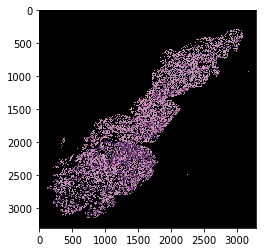

In [5]:
show_multiple_images_big(rois_filtered_path)

# Create tiles

## multi process

In [6]:
tiles.multiprocess_filtered_images_to_tiles(display=False, 
                                            save_summary=False, 
                                            save_data=False, 
                                            save_top_tiles=True,
                                            html=True, 
                                            image_num_list=list(range(0, len(rois_filtered_path.ls()))))

Generating tile summaries (multiprocess)

Number of processes: 1
Number of training images: 1
Task #1: Process slides [0]
RGB                  | Time: 0:00:00.240420  Type: uint8   Shape: (3299, 3278, 3)
RGB                  | Time: 0:00:00.230286  Type: uint8   Shape: (3299, 3278, 3)
tp: 0.002384185791015625
cf: 194.6545030641918
score: 4.640709631764661e-05
tp: 4.573345184326172
cf: 565.8568466450259
score: 0.20558370962517114
tp: 24.736881256103516
cf: 658.3977768818813
score: 0.6195795935240895
tp: 0.18298695388349984
cf: 66.75888953939817
score: 0.0012201100969387868
tp: 4.763126373291016
cf: 477.9014699548919
score: 0.185422655896191
tp: 42.12007522583008
cf: 681.8906792230375
score: 0.7417441192935669
tp: 6.811428070068359
cf: 728.7700779947869
score: 0.33172791951854264
tp: 0.012799605582529239
cf: 282.1334684559393
score: 0.00036098935141604116
tp: 36.30714416503906
cf: 1164.2384155029981
score: 0.8086863000733893
tp: 35.68267822265625
cf: 1369.8967870295899
score: 0.830167618

IndexError: list index out of range

In [7]:
len(tiles_path.ls())

4

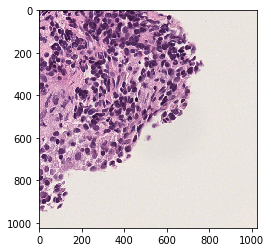

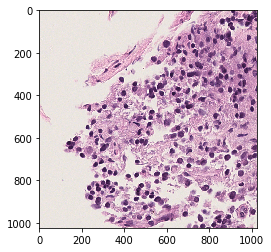

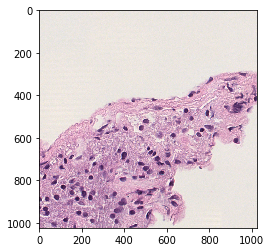

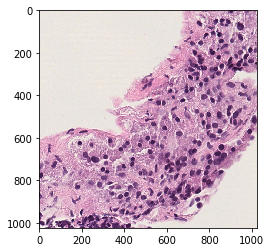

In [8]:
show_multiple_images_big(tiles_path)

In [5]:
#!rm -r {rois_path/'*'}
!rm -r {rois_filtered_path/'*'}
!rm -r {tiles_path/'*'}

rm: cannot remove '/home/Deep_Learner/work/network/datasets/Hypophysenadenome/rois_experimenting_filtered/*': No such file or directory
rm: cannot remove '/home/Deep_Learner/work/network/datasets/Hypophysenadenome/tiles_experimenting/*': No such file or directory


## single process

In [ ]:
#!rm -r {tiles_path/'*'}
for n, p in tqdm(enumerate(rois_filtered_path.ls()), total=len(rois_filtered_path.ls())-1):
    if p.suffix == '.png':
        tiles.summary_and_tiles(n, display=False, save_summary=False, save_data=False, save_top_tiles=True)

# exp

In [ ]:
import PIL
p = '/home/Deep_Learner/work/network/datasets/Hypophysenadenome/rois_corticotrop/1000-13-III-HE-ROI_1-ACTH.png'

img_pil = slide.open_image(p)
img_np = util.pil_to_np_rgb(img_pil)
grayscale_np = filter.filter_rgb_to_grayscale(img_np)
complement_np = filter.filter_complement(grayscale_np)
otsu_np = filter.filter_otsu_threshold(complement_np).astype(np.bool)
filtered_img_np = util.mask_rgb(img_np, otsu_np)

plt.imshow(filtered_img_np)

tiles = []
sz = 512
for i in range(int(filtered_img_np.shape[0]/sz)):
    for j in range(int(filtered_img_np.shape[1]/sz)):
         tiles.append(filtered_img_np[i*sz:(i+1)*sz,j*sz:(j+1)*sz])
        

for t in tiles:
    print(t.shape)
    nz = np.count_nonzero(t)// 3
    print(f'tissue percentage:{(nz/(t.shape[0]*t.shape[1]))*100}')
    plt.imshow(t)
    plt.show()